In [1]:
import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional, Conv1D, Concatenate
import matplotlib.pyplot as plt

2025-04-13 09:33:35.280473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jonathonlopes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Set up directories
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

DIRECTORY = '.'
SUMMARY_PATH = 'NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = 'NLP_app/MutualFundLabels.csv'

glove_word2vec = 'NLP_app/word2vec_perso.txt'
our_word2vec = 'NLP_app/word2vec_perso.txt'

# Utility functions
 

In [79]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename, word2vec):
    with open(os.path.join('./', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('./', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    
    # Uses only funds in rag_preds, which are funds with the 3 relevant strategies
    rag_preds = pd.read_csv("rag_predictions.csv")
    relevant_funds = list(rag_preds['fund_name'])
    
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        if fund_name in relevant_funds:
            texts.append(summary)
            fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

## Tokenize fund summaries

In [7]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

In [12]:
# Get the summaries that use one of the 3 relevant investment strategies
fund_names, summaries = get_data(SUMMARY_PATH)

In [38]:
# Clean and tokenize text - remove whitespace, tokenize words, keep only alphabetic chars, remove stopwords
def tokenizer(txt: str) -> list[str]:
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = []
    for w in word_tokens:
        w_clean = re.sub(r'[^a-zA-Z]', '', w)
        if w_clean and w_clean not in stop_words:
            filtered_sentence.append(w_clean)
    
    return filtered_sentence

In [50]:
# Make one list of all tokenized words from each summary
text_words = np.concatenate([tokenizer(summary) for summary in summaries])

## Set up for skip-gram model

In [42]:
# Training Parameters
batch_size = 128 # The model will be trained batch per batch and one batch contains 128 rows
num_epochs = 2 # The model will go through all the data twice

In [43]:
# Word2Vec Parameters
embedding_size = 50 # Dimension of the embedding vector, also size of hidden layer
max_vocabulary_size = 5000 # Total number of different words in the vocabulary
min_occurrence = 10 # Remove all words that does not appears at least n times
skip_window = 3 # How many words to consider left and right
num_skips = 4 # How many times to reuse an input to generate a label

In [51]:
# Makes dictionary of words to word frequency for frequency > min_occurrence
count = [('UNK', -1)]
# Retrieve the most common words
count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [ ]:
# Create id's for each word and create 2 dictionary to access in both directions
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)   

In [62]:
# Create data - list of text_words where words are converted to their id's
data = list()
unk_count = 0
for word in text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

In [67]:
# Build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [68]:
# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs 
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

## Train the skip-gram model

In [69]:
# Create and compile the Autoencoder
def creat_word2vec_model():
    # One-hot encoded vector input vector
    input_word = Input(shape=(vocab_size,))
    # Embedded layer - maps input vector to embedding vector
    encoded = Dense(embedding_size, activation='linear')(input_word)
    # Output layer - maps embedding vector to probability of a context word
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    # The autoencoder is the whole model with hidden layer contected to the output layer.
    autoencoder = Model(input_word, decoded)
    # The encoder is just the input layer connected to the hidden layer. One the Autoencoder will be trained we will use
    # the encoder to create our word vectors 
    encoder = Model(input_word, encoded)
    
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

In [ ]:
# Create word2vec model
encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

In [72]:
# Train model using batch generator
autoencoder.fit(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2
6363/6363 ━━━━━━━━━━━━━━━━━━━━ 79s 12ms/step - loss: 0.0613
Epoch 2/2
6363/6363 ━━━━━━━━━━━━━━━━━━━━ 83s 13ms/step - loss: 0.0024


## Use encoder

In [73]:
# Word to one_hot vecotor to dense vector
def vectorize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

In [74]:
# Create the word2vec dictionary - dictionary of word to dense vector
word2vec = {w : vectorize(w) for w in word2id.keys()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [82]:
# We can save the word2vec dictionary to reuse it later.
save_word2vec(our_word2vec, word2vec)

# C- Sentence extraction

<h3> 1_ Create a knowledge base </h3>

In [83]:
equity_keywords = [
    "equity", "equities", "stock", "stocks", "shares", "common", "capital",
    "appreciation", "growth", "dividends", "midcap",
    "technology", "healthcare", "consumer", "industrials", "portfolio"
]
fixed_income_keywords = [
    "bond", "bonds", "debt", "coupon", "yield", "duration", "interest", "income",
    "fixed", "maturity", "treasury", "municipal", "corporate", "principal", "credit", "rates", "stable"
]
balanced_keywords = [
    "balanced", "diversified", "allocation", "blend", "mix", "strategy",
    "equities", "bonds", "stocks", "fixed", "income", "growth", "capital", 
    "preservation", "stability", "moderate", "hybrid", "rebalancing"
]

In [84]:
def get_n_closer(w, n, word2vec):
    vect = word2vec[w]
    distances_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    
    closer_words = []
    for _ in range(n):
        min_key = min(distances_dict.keys(), key=lambda k: distances_dict[k])
        closer_words.append(min_key)
        del distances_dict[min_key]
    return closer_words

In [85]:
# Creates the knwoledge base by taking the num_neighbors closes neighbors of each key_words in word2vec
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

In [86]:
#word2vec = load_word2vec(our_word2vec)
eq_knowledge_base = create_knowledge_base(5, word2vec, equity_keywords)
fi_knowledge_base = create_knowledge_base(5, word2vec, fixed_income_keywords)
bal_knowledge_base = create_knowledge_base(5, word2vec, balanced_keywords)

In [87]:
df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv('rag_predictions.csv')
df = df_label.merge(df_extraction, on='fund_name', how='left').dropna()

In [88]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

In [89]:
df['eq_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], eq_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['fi_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], fi_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
df['bal_sentences'] = df.apply(lambda x : extract_sentence_distance(x['summary'], bal_knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [90]:
df.to_csv("dataset.csv")

## Making the Model

In [91]:
X = df[['eq_sentences', 'fi_sentences', 'bal_sentences']]
for col in ['eq_sentences', 'fi_sentences', 'bal_sentences']:
    X[col] = X[col].fillna('').apply(lambda txt: ' '.join(tokenizer(txt)))

y = df['Predicted Investment Strategy'].values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


/var/folders/jx/vhdxb7ks06710zlsb29bkz000000gn/T/ipykernel_48601/2951265711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna('').apply(lambda txt: ' '.join(tokenizer(txt)))


In [92]:
# num_words - Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
# maxlen - Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
# word_dimension - dimension of our word vectors.
def run_CNN(num_words, maxlen, word_dimension):    
    word2vec_g = word2vec
    tokenizer_eq = Tokenizer(num_words=num_words)
    tokenizer_fi = Tokenizer(num_words=num_words)
    tokenizer_bal = Tokenizer(num_words=num_words)

    # Fit on texts
    tokenizer_eq.fit_on_texts(X['eq_sentences'])
    tokenizer_fi.fit_on_texts(X['fi_sentences'])
    tokenizer_bal.fit_on_texts(X['bal_sentences'])
    word_index_eq = tokenizer_eq.word_index
    word_index_fi = tokenizer_fi.word_index
    word_index_bal = tokenizer_bal.word_index

    # Convert texts to sequences
    seq_eq = tokenizer_eq.texts_to_sequences(X['eq_sentences'])
    seq_fi = tokenizer_fi.texts_to_sequences(X['fi_sentences'])
    seq_bal = tokenizer_bal.texts_to_sequences(X['bal_sentences'])

    # Pad sequences to uniform length
    X_eq = pad_sequences(seq_eq, maxlen=maxlen, padding='post')
    X_fi = pad_sequences(seq_fi, maxlen=maxlen, padding='post')
    X_bal = pad_sequences(seq_bal, maxlen=maxlen, padding='post')

    # First split: train + temp (temp will later be split into val and test)
    X_eq_train, X_eq_temp, X_fi_train, X_fi_temp, X_bal_train, X_bal_temp, y_train, y_temp = train_test_split(
        X_eq, X_fi, X_bal, y, test_size=0.3, random_state=42
    )

    # Second split: temp → val and test (e.g., 15% each)
    X_eq_val, X_eq_test, X_fi_val, X_fi_test, X_bal_val, X_bal_test, y_val, y_test = train_test_split(
        X_eq_temp, X_fi_temp, X_bal_temp, y_temp, test_size=0.5, random_state=42
    )

    embedding_matrix_eq = np.zeros((len(word_index_eq) + 1, word_dimension))
    for word, i in word_index_eq.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_eq[i] = embedding_vector

    embedding_matrix_fi = np.zeros((len(word_index_fi) + 1, word_dimension))
    for word, i in word_index_fi.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_fi[i] = embedding_vector
            
    embedding_matrix_bal = np.zeros((len(word_index_bal) + 1, word_dimension))
    for word, i in word_index_bal.items():
        embedding_vector = word2vec_g.get(word)
        if embedding_vector is not None:
            embedding_matrix_bal[i] = embedding_vector

    def create_CNN_branch(input_shape, embedding_matrix, name_prefix="input"):
        input_layer = Input(shape=input_shape, name=f"{name_prefix}_input")

        x = Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=input_shape[0],
            trainable=False,
            name=f"{name_prefix}_embedding"
        )(input_layer)

        x = Conv1D(64, 5, activation='relu')(x)
        x = MaxPooling1D(pool_size=5)(x)

        x = Conv1D(32, 5, activation='relu')(x)
        x = MaxPooling1D(pool_size=5)(x)

        x = Flatten()(x)
        return input_layer, x

    def create_CNN_model_multi_input(embedding_eq, embedding_fi, embedding_bal, maxlen):
        # Each branch
        eq_input, eq_branch = create_CNN_branch((maxlen,), embedding_eq, "eq")
        fi_input, fi_branch = create_CNN_branch((maxlen,), embedding_fi, "fi")
        bal_input, bal_branch = create_CNN_branch((maxlen,), embedding_bal, "bal")

        # Merge
        merged = Concatenate()([eq_branch, fi_branch, bal_branch])
        x = Dense(128, activation='relu')(merged)
        x = Dropout(0.5)(x)
        output = Dense(3, activation='softmax')(x)

        model = Model(inputs=[eq_input, fi_input, bal_input], outputs=output)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    CNN_model = create_CNN_model_multi_input(embedding_matrix_eq, embedding_matrix_fi, embedding_matrix_bal, maxlen)

    CNN_history = CNN_model.fit(
        [X_eq_train, X_fi_train, X_bal_train], y_train,
        validation_data=([X_eq_val, X_fi_val, X_bal_val], y_val),
        epochs=10,
        batch_size=32
    )

    acc = CNN_history.history['accuracy']
    val_acc = CNN_history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Predict labels
    y_pred = CNN_model.predict([X_eq_test, X_fi_test, X_bal_test])
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Balanced', 'Equity', 'Fixed Income'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()





Num_words: 1500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4615 - loss: 1.1112 - val_accuracy: 0.5217 - val_loss: 1.0485
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4881 - loss: 1.0466 - val_accuracy: 0.5217 - val_loss: 1.0273
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5515 - loss: 1.0088 - val_accuracy: 0.5217 - val_loss: 1.0102
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5048 - loss: 1.0377 - val_accuracy: 0.5217 - val_loss: 1.0109
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5702 - loss: 1.0289 - val_accuracy: 0.5217 - val_loss: 0.9952
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5628 - loss: 1.0057 - val_accuracy: 0.5217 - val_loss: 0.9985
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5701 - loss: 0.9910 - val_accuracy: 0.5217 - val_loss: 0.9935
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5526 - loss: 1.0032 - val_accuracy: 0.5217 - val_loss: 0.

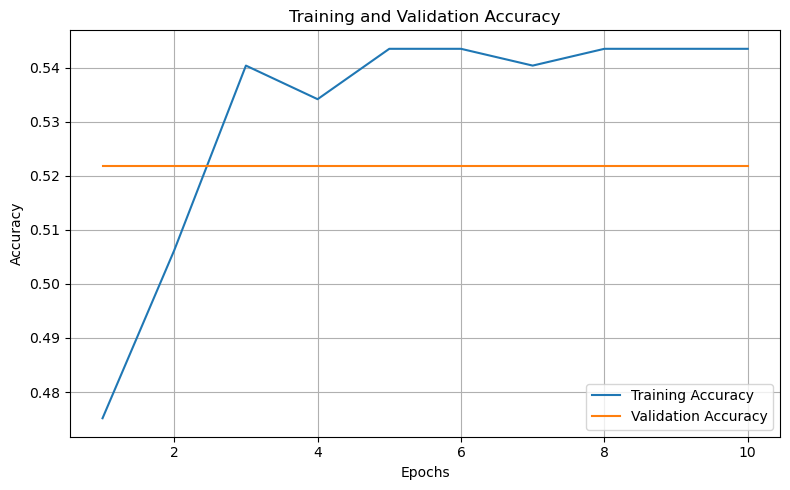

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


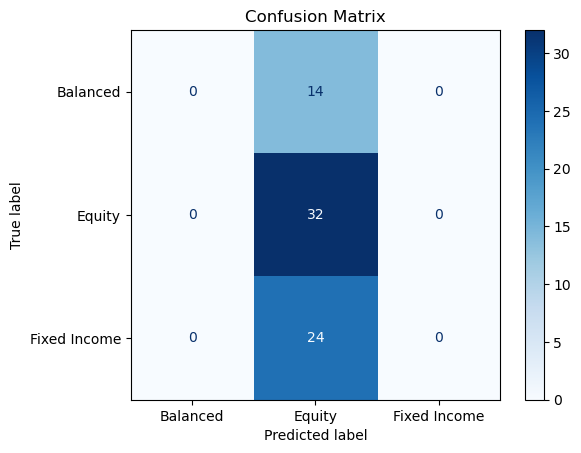




Num_words: 1500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4389 - loss: 1.1149 - val_accuracy: 0.5072 - val_loss: 1.0286
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4416 - loss: 1.0453 - val_accuracy: 0.5217 - val_loss: 0.9897
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5399 - loss: 0.9979 - val_accuracy: 0.5072 - val_loss: 0.9902
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5548 - loss: 0.9974 - val_accuracy: 0.5217 - val_loss: 0.9779
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5277 - loss: 0.9893 - val_accuracy: 0.5217 - val_loss: 0.9592
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5866 - loss: 0.9340 - val_accuracy: 0.4783 - val_loss: 0.9473
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5420 - loss: 0.9637 - val_accuracy: 0.5217 - val_loss: 0.9556
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5052 - loss: 0.9514 - val_accuracy: 0.5217 - val_loss: 0.

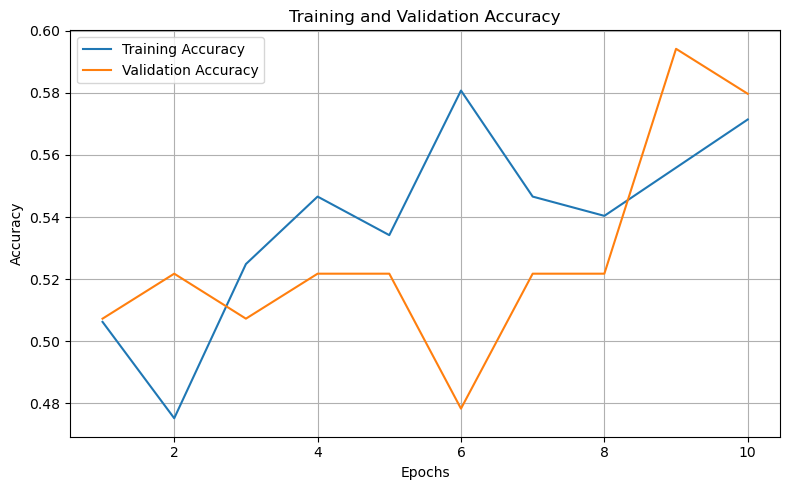

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/stepWARNING:tensorflow:5 out of the last 3111 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x13e886e80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


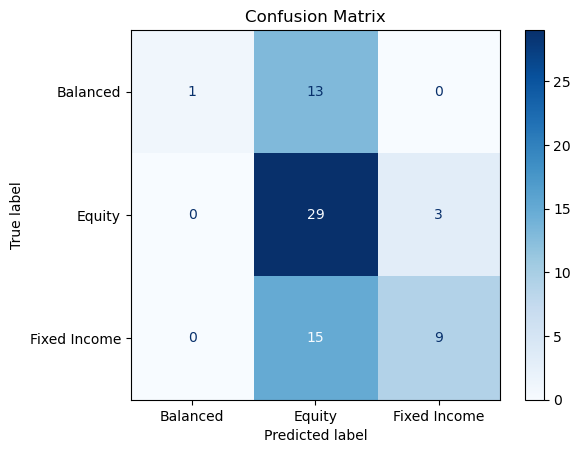




Num_words: 1500
maxlen: 250
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.4714 - loss: 1.0487 - val_accuracy: 0.5217 - val_loss: 1.0243
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5342 - loss: 1.0503 - val_accuracy: 0.5217 - val_loss: 0.9732
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5170 - loss: 1.0064 - val_accuracy: 0.5217 - val_loss: 0.9681
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5462 - loss: 0.9903 - val_accuracy: 0.5217 - val_loss: 0.9633
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5666 - loss: 0.9469 - val_accuracy: 0.5217 - val_loss: 0.9378
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5508 - loss: 0.9235 - val_accuracy: 0.5652 - val_loss: 0.9426
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5572 - loss: 0.9278 - val_accuracy: 0.5652 - val_loss: 0.9281
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5937 - loss: 0.8867 - val_accuracy: 0.5797 - val_loss: 0.

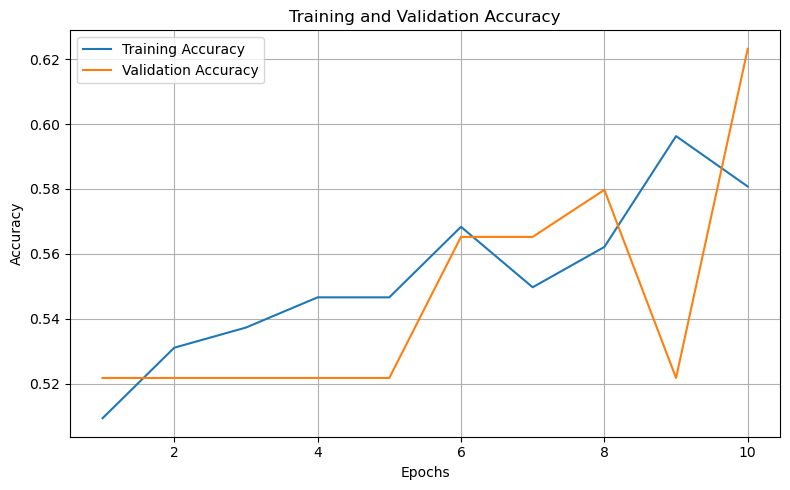

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


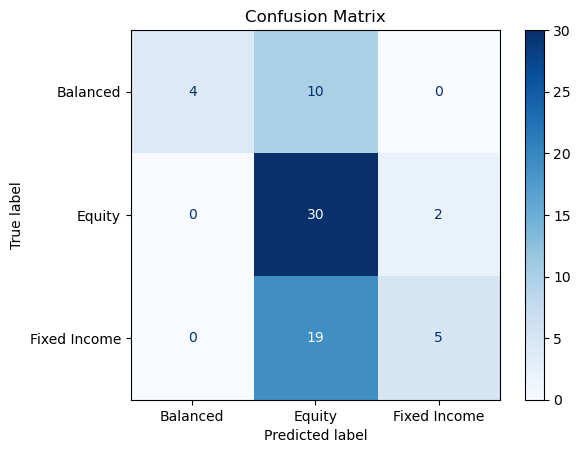




Num_words: 1500
maxlen: 350
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.4253 - loss: 1.1221 - val_accuracy: 0.5217 - val_loss: 0.9860
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5708 - loss: 0.9716 - val_accuracy: 0.5217 - val_loss: 0.9728
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5374 - loss: 0.9819 - val_accuracy: 0.4928 - val_loss: 0.9602
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5439 - loss: 0.9733 - val_accuracy: 0.5217 - val_loss: 0.9725
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5746 - loss: 0.9651 - val_accuracy: 0.5217 - val_loss: 0.9651
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5435 - loss: 0.9806 - val_accuracy: 0.5217 - val_loss: 0.9454
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5584 - loss: 0.9758 - val_accuracy: 0.6377 - val_loss: 0.9238
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5110 - loss: 0.9549 - val_accuracy: 0.5652 - val_loss: 0.

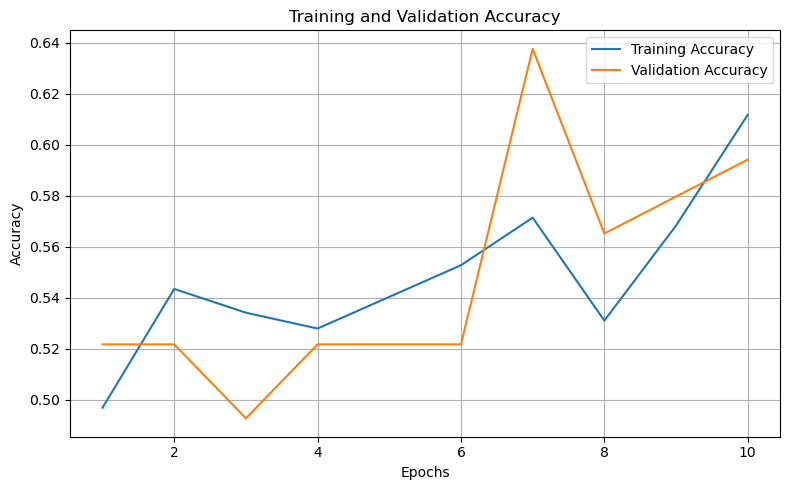

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


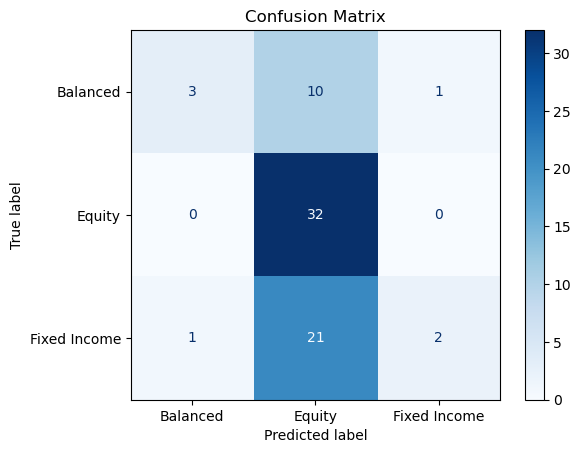




Num_words: 2500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.4493 - loss: 1.0632 - val_accuracy: 0.5217 - val_loss: 1.0266
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5361 - loss: 1.0398 - val_accuracy: 0.5217 - val_loss: 1.0298
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5476 - loss: 1.0320 - val_accuracy: 0.5217 - val_loss: 0.9870
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5750 - loss: 1.0182 - val_accuracy: 0.5652 - val_loss: 0.9897
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5081 - loss: 1.0235 - val_accuracy: 0.5217 - val_loss: 0.9659
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5654 - loss: 0.9663 - val_accuracy: 0.5507 - val_loss: 0.9396
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5447 - loss: 1.0032 - val_accuracy: 0.5362 - val_loss: 0.9291
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5572 - loss: 0.9598 - val_accuracy: 0.5507 - val_loss: 0.

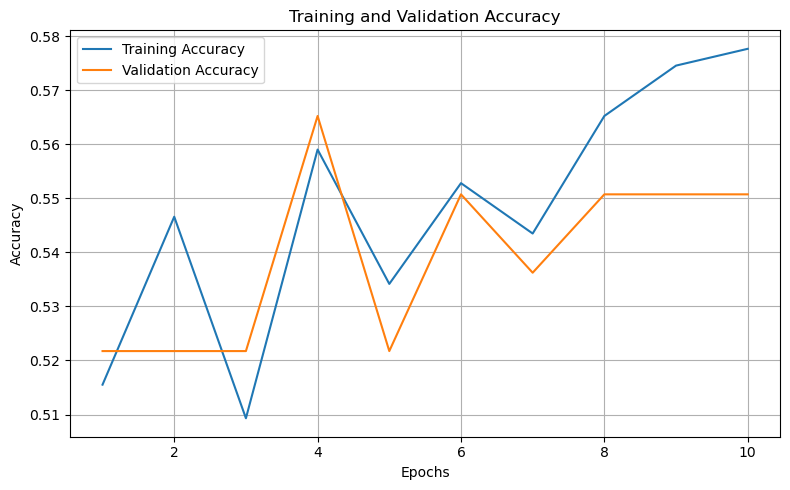

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


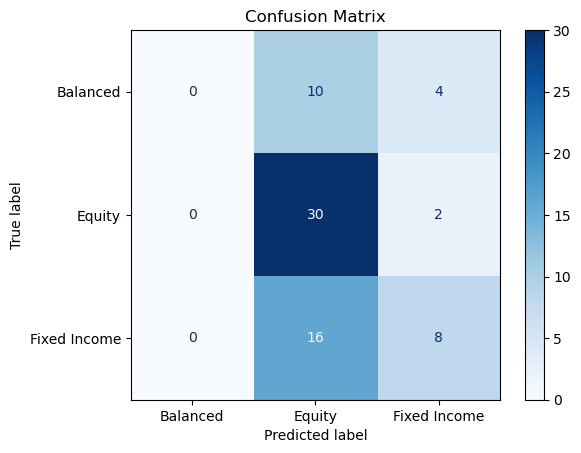




Num_words: 2500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.5011 - loss: 1.0605 - val_accuracy: 0.5217 - val_loss: 1.0094
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5557 - loss: 0.9987 - val_accuracy: 0.4928 - val_loss: 0.9944
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5215 - loss: 1.0387 - val_accuracy: 0.5217 - val_loss: 0.9857
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5532 - loss: 1.0045 - val_accuracy: 0.5217 - val_loss: 0.9739
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5662 - loss: 0.9711 - val_accuracy: 0.5072 - val_loss: 0.9678
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5512 - loss: 0.9916 - val_accuracy: 0.5217 - val_loss: 0.9430
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5336 - loss: 0.9894 - val_accuracy: 0.5217 - val_loss: 0.9329
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5440 - loss: 0.9709 - val_accuracy: 0.5362 - val_loss: 0.

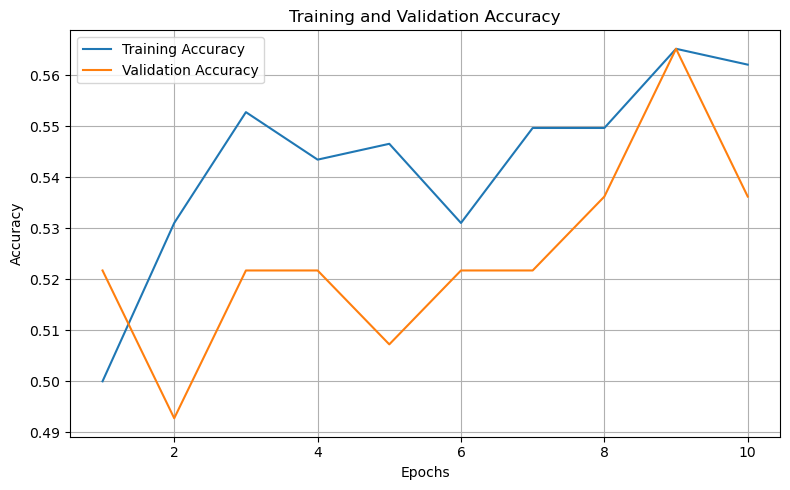

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


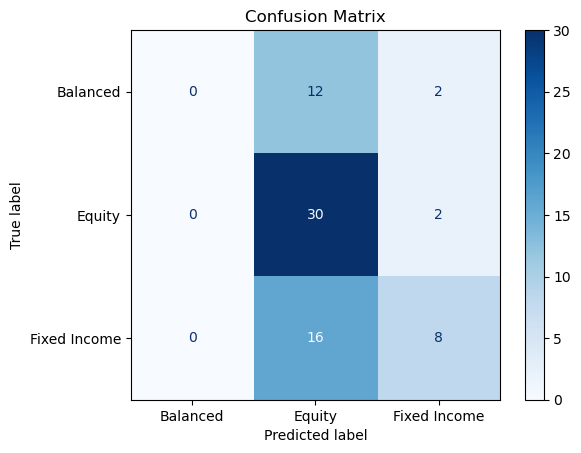




Num_words: 2500
maxlen: 250


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5331 - loss: 1.0293 - val_accuracy: 0.5217 - val_loss: 1.0157
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4838 - loss: 1.0117 - val_accuracy: 0.5217 - val_loss: 0.9713
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5886 - loss: 0.9602 - val_accuracy: 0.5217 - val_loss: 0.9530
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5294 - loss: 0.9726 - val_accuracy: 0.5217 - val_loss: 0.9204
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5682 - loss: 0.9205 - val_accuracy: 0.5797 - val_loss: 0.9042
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5652 - loss: 0.9147 - val_accuracy: 0.6812 - val_loss: 0.8802
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5943 - loss: 0.9256 - val_accuracy: 0.5507 - val_loss: 0.8916
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5742 - loss: 0.9573 - val_accuracy: 0.6087 - v

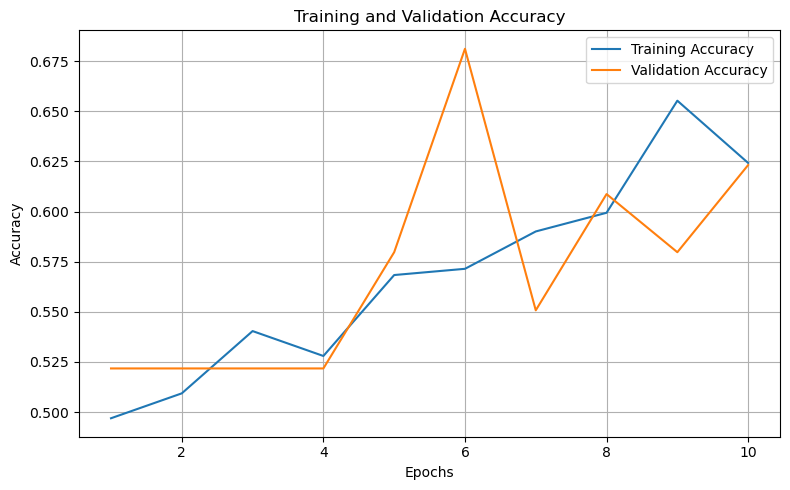

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


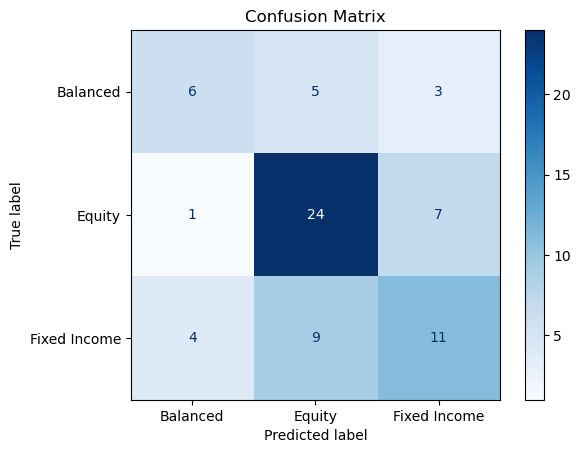




Num_words: 2500
maxlen: 350


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.4845 - loss: 1.0708 - val_accuracy: 0.5217 - val_loss: 0.9674
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5682 - loss: 0.9859 - val_accuracy: 0.5217 - val_loss: 0.9509
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5466 - loss: 0.9862 - val_accuracy: 0.4928 - val_loss: 0.9515
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5836 - loss: 0.9584 - val_accuracy: 0.5507 - val_loss: 0.9186
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5762 - loss: 0.9436 - val_accuracy: 0.5652 - val_loss: 0.9142
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5732 - loss: 0.9401 - val_accuracy: 0.5652 - val_loss: 0.8884
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5827 - loss: 0.9252 - val_accuracy: 0.6522 - val_loss: 0.8651
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6026 - loss: 0.9154 - val_accuracy: 0.6377 - v

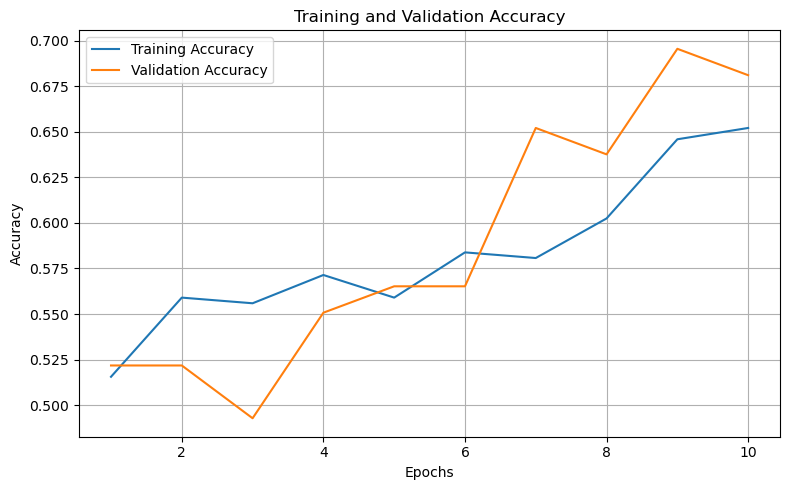

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


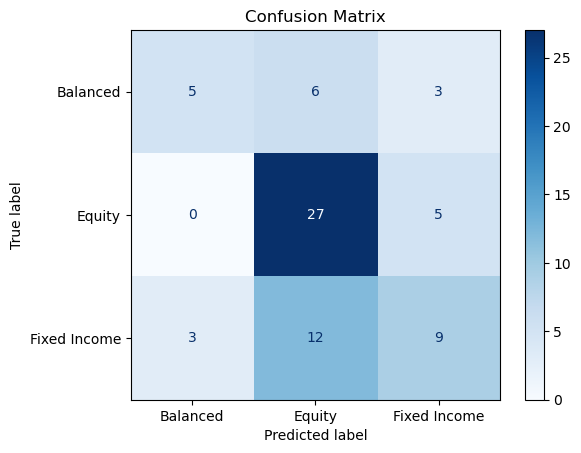




Num_words: 3500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.4964 - loss: 1.0972 - val_accuracy: 0.5217 - val_loss: 1.0095
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5530 - loss: 1.0167 - val_accuracy: 0.5217 - val_loss: 0.9988
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5550 - loss: 0.9901 - val_accuracy: 0.5217 - val_loss: 0.9888
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5754 - loss: 0.9705 - val_accuracy: 0.5217 - val_loss: 0.9832
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5583 - loss: 0.9885 - val_accuracy: 0.4928 - val_loss: 0.9696
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5555 - loss: 0.9334 - val_accuracy: 0.5942 - val_loss: 0.9562
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5739 - loss: 0.9507 - val_accuracy: 0.5652 - val_loss: 1.0032
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4985 - loss: 0.9889 - val_accuracy: 0.4783 - val_loss: 0.

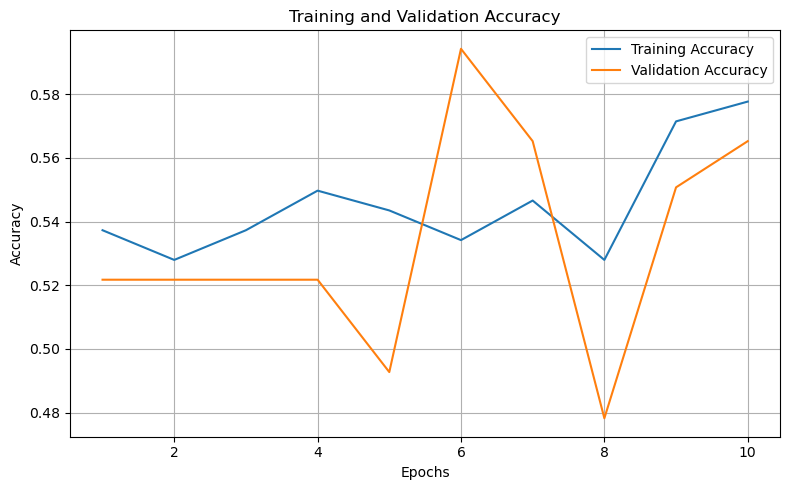

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


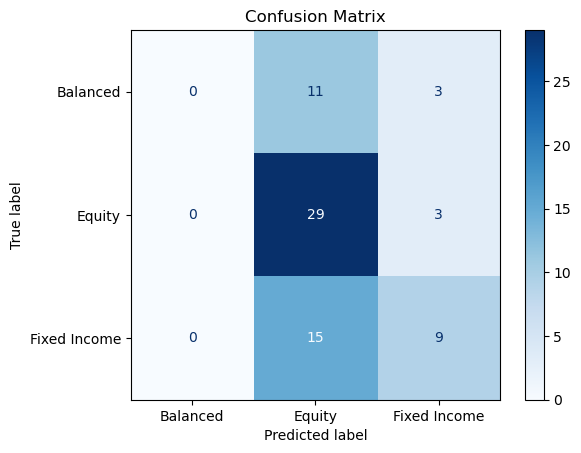




Num_words: 3500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.4994 - loss: 1.1252 - val_accuracy: 0.5217 - val_loss: 0.9875
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5651 - loss: 0.9932 - val_accuracy: 0.5217 - val_loss: 0.9841
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5530 - loss: 0.9974 - val_accuracy: 0.5217 - val_loss: 0.9751
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5642 - loss: 0.9887 - val_accuracy: 0.5072 - val_loss: 0.9652
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5388 - loss: 0.9754 - val_accuracy: 0.5072 - val_loss: 0.9343
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5646 - loss: 0.9585 - val_accuracy: 0.5072 - val_loss: 0.9406
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5600 - loss: 0.9459 - val_accuracy: 0.5072 - val_loss: 0.9167
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5402 - loss: 0.9275 - val_accuracy: 0.5217 - val_loss: 0

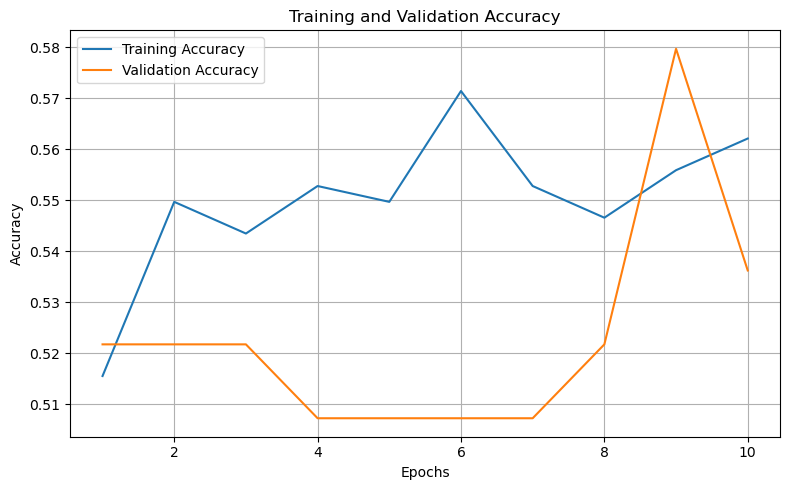

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


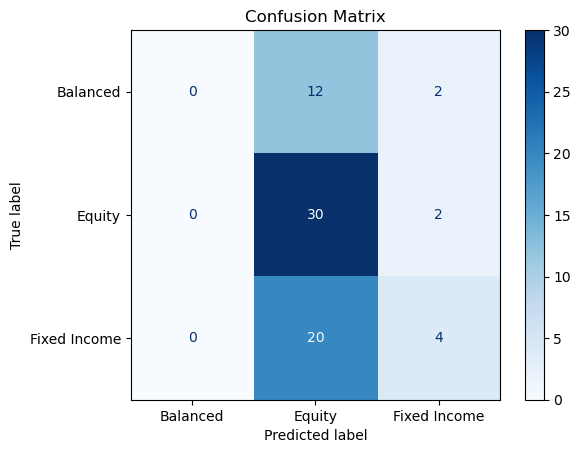




Num_words: 3500
maxlen: 250
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.4623 - loss: 1.0868 - val_accuracy: 0.5217 - val_loss: 0.9897
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5136 - loss: 1.0688 - val_accuracy: 0.5217 - val_loss: 0.9916
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5345 - loss: 0.9713 - val_accuracy: 0.5217 - val_loss: 0.9740
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5765 - loss: 0.9564 - val_accuracy: 0.5217 - val_loss: 0.9566
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5916 - loss: 0.9295 - val_accuracy: 0.5217 - val_loss: 0.9202
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5774 - loss: 0.9200 - val_accuracy: 0.5217 - val_loss: 0.9034
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6304 - loss: 0.8990 - val_accuracy: 0.5217 - val_loss: 0.8810
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6084 - loss: 0.8969 - val_accuracy: 0.6232 - val_loss: 0.

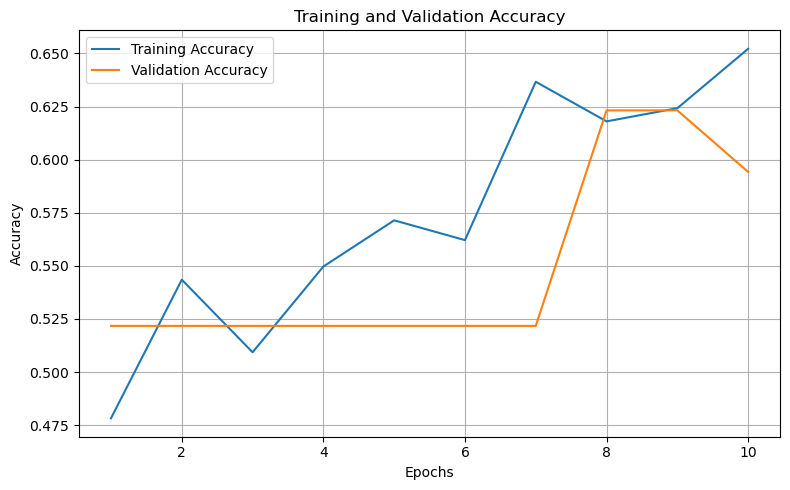

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


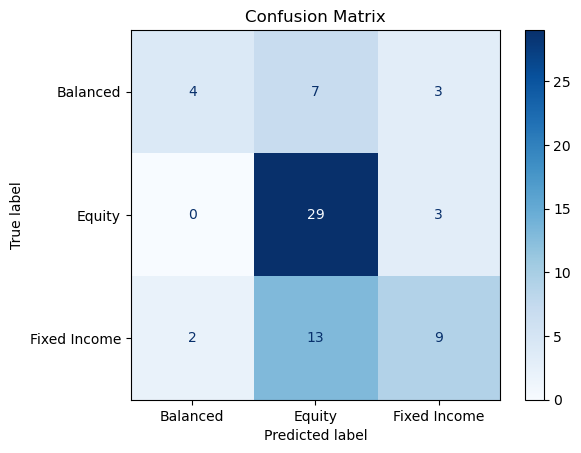




Num_words: 3500
maxlen: 350


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.4749 - loss: 1.0765 - val_accuracy: 0.5217 - val_loss: 0.9781
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5404 - loss: 1.0055 - val_accuracy: 0.5217 - val_loss: 0.9819
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5767 - loss: 0.9638 - val_accuracy: 0.5217 - val_loss: 0.9652
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5495 - loss: 0.9723 - val_accuracy: 0.5217 - val_loss: 0.9414
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5415 - loss: 0.9719 - val_accuracy: 0.5362 - val_loss: 0.9335
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5561 - loss: 0.9532 - val_accuracy: 0.5507 - val_loss: 0.9342
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5981 - loss: 0.9200 - val_accuracy: 0.5072 - val_loss: 0.9044
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5770 - loss: 0.9290 - val_accuracy: 0.5217 - v

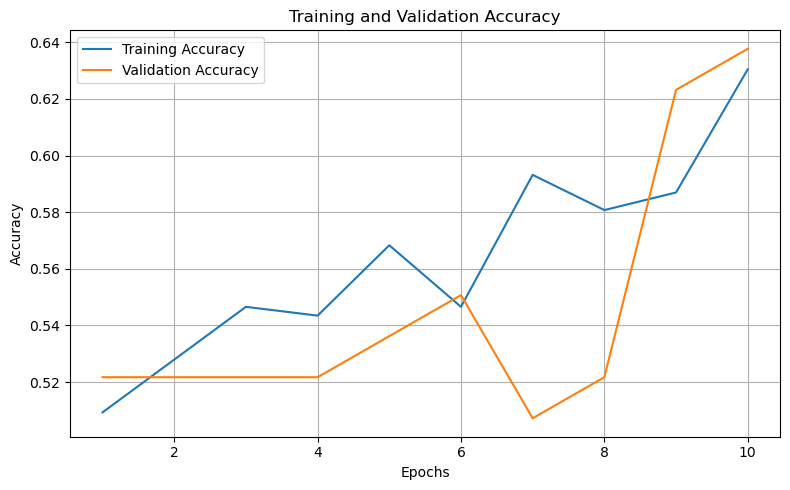

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


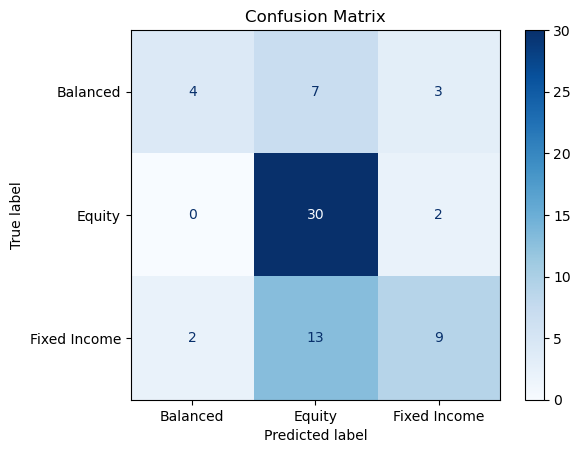




Num_words: 4500
maxlen: 100
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4374 - loss: 1.1423 - val_accuracy: 0.5217 - val_loss: 0.9990
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5211 - loss: 1.0126 - val_accuracy: 0.5217 - val_loss: 0.9878
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5178 - loss: 1.0100 - val_accuracy: 0.5217 - val_loss: 1.0074
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5032 - loss: 1.0185 - val_accuracy: 0.5217 - val_loss: 0.9830
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5340 - loss: 1.0281 - val_accuracy: 0.4928 - val_loss: 0.9745
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4887 - loss: 0.9953 - val_accuracy: 0.4928 - val_loss: 0.9515
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5327 - loss: 0.9848 - val_accuracy: 0.5072 - val_loss: 0.9505
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5747 - loss: 0.9338 - val_accuracy: 0.5072 - val_loss: 0.

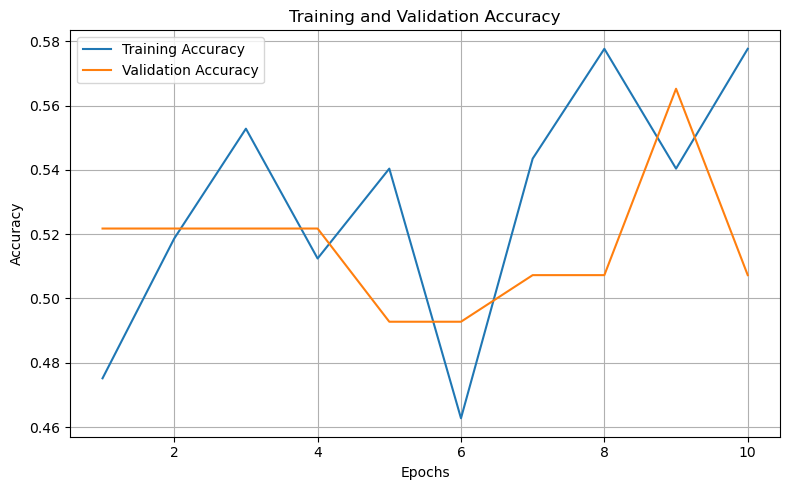

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


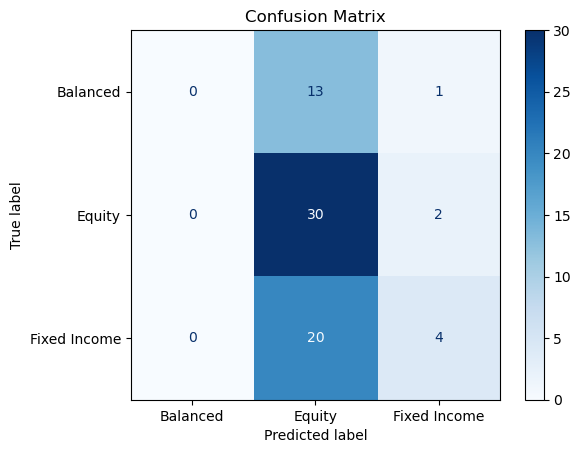




Num_words: 4500
maxlen: 150
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5647 - loss: 1.0905 - val_accuracy: 0.5217 - val_loss: 1.0026
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5475 - loss: 0.9971 - val_accuracy: 0.5217 - val_loss: 0.9806
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5587 - loss: 0.9937 - val_accuracy: 0.5217 - val_loss: 0.9596
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5216 - loss: 0.9970 - val_accuracy: 0.5217 - val_loss: 0.9523
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5154 - loss: 0.9916 - val_accuracy: 0.5217 - val_loss: 0.9602
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5125 - loss: 1.0021 - val_accuracy: 0.5217 - val_loss: 0.9580
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5421 - loss: 0.9450 - val_accuracy: 0.5507 - val_loss: 0.9359
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5915 - loss: 0.9469 - val_accuracy: 0.5217 - val_loss: 0.

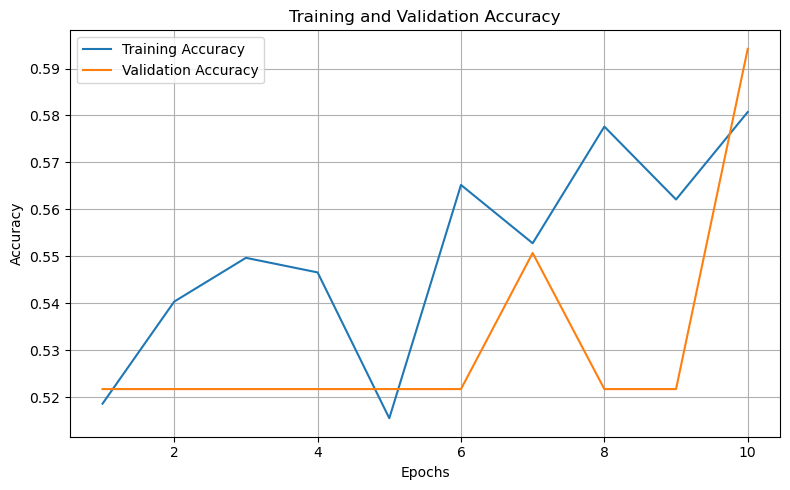

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


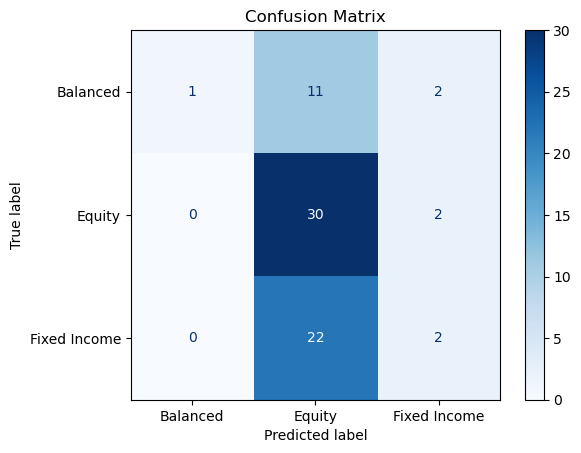




Num_words: 4500
maxlen: 250
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.4671 - loss: 1.0765 - val_accuracy: 0.5217 - val_loss: 0.9874
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5462 - loss: 1.0151 - val_accuracy: 0.5217 - val_loss: 0.9884
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5290 - loss: 0.9813 - val_accuracy: 0.5217 - val_loss: 0.9700
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5616 - loss: 0.9539 - val_accuracy: 0.5217 - val_loss: 0.9657
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5580 - loss: 0.9492 - val_accuracy: 0.5217 - val_loss: 0.9284
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5841 - loss: 0.8890 - val_accuracy: 0.6087 - val_loss: 0.8804
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5727 - loss: 0.9172 - val_accuracy: 0.5652 - val_loss: 0.8820
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5617 - loss: 0.8762 - val_accuracy: 0.5942 - val_loss: 0.

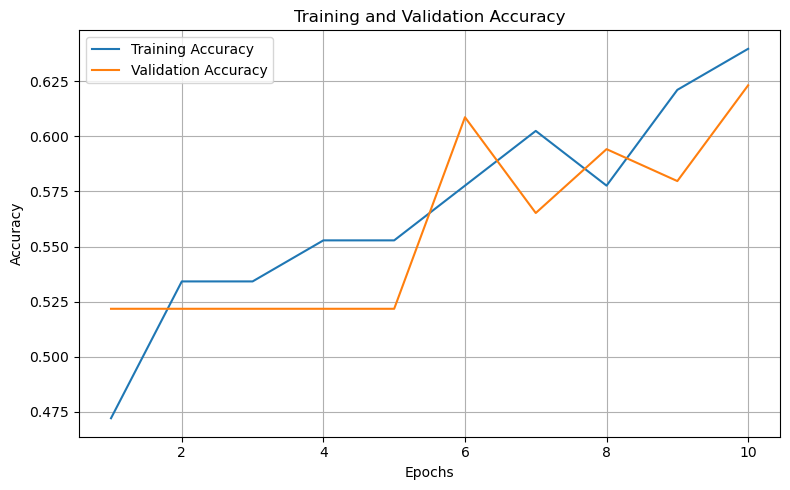

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


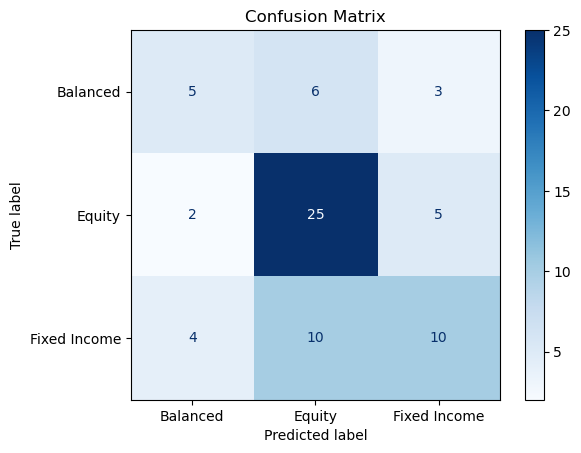




Num_words: 4500
maxlen: 350
Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.4633 - loss: 1.0783 - val_accuracy: 0.5217 - val_loss: 0.9901
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5454 - loss: 0.9968 - val_accuracy: 0.5217 - val_loss: 0.9954
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5648 - loss: 0.9778 - val_accuracy: 0.5217 - val_loss: 0.9727
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5543 - loss: 0.9618 - val_accuracy: 0.5217 - val_loss: 0.9473
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5326 - loss: 0.9603 - val_accuracy: 0.5217 - val_loss: 0.9294
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6029 - loss: 0.8997 - val_accuracy: 0.4928 - val_loss: 0.9337
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5831 - loss: 0.8879 - val_accuracy: 0.5507 - val_loss: 0.9340
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5494 - loss: 0.9388 - val_accuracy: 0.4783 - val_loss: 0

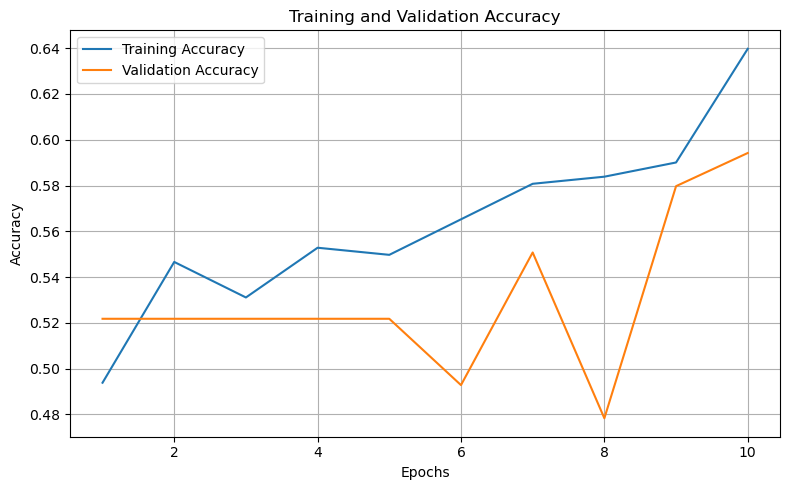

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


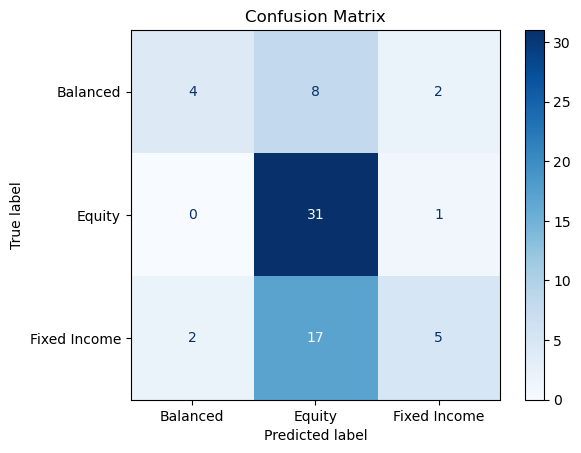

In [93]:
for num_words in [1500, 2500, 3500, 4500]:
    for maxlen in [100, 150, 250, 350]:
        print()
        print()
        print()
        print("Num_words: " + str(num_words))
        print("maxlen: " + str(maxlen))
        run_CNN(num_words, maxlen, 50)